# Model optimisation

Model optimised based on data from [Tsutsumi _et al._ 2011](https://doi.org/10.1038/nsmb.2125).

This notebook only shows the optimisation strategy, the actual optimised paramters used in the model can be found in ``params.py``.

## Setup

In [1]:
#setup workspace
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from scipy.integrate import solve_ivp
import  model_utils as mu
from scipy.optimize import curve_fit
import cma

C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#set up initial conditions
##initial concentrations (nM) as outlined in Tsutsumi et al.
pre_wt = 1
pre_sl = 1
wt_dcr = 0
sl_dcr = 0
wt_dcr_star = 0
sl_dcr_star = 0
dcr_wt = 5 #free Dicer in WT system
dcr_sl = 5 #free Dicer in SL system
wt = 0
sl = 0

init_values = [pre_wt, pre_sl, wt_dcr, sl_dcr, wt_dcr_star, sl_dcr_star, dcr_wt, dcr_sl, wt, sl]

##measured affinities for wt, sl pre-miRNAs (nM)
Kd_wt = 25.4
Kd_sl = 147.7

##initial theta (reaction rates) to be optimised:
ka_wt = 5
ka_sl = 5
kc_wt = .1
kc_sl = .1
kd = 5 

theta = np.log(np.array([ka_wt, ka_sl, kc_wt, kc_sl, kd, kd])) #log theta to prevent negative reaction rates in optimisation

#experimental data from figure 1, tsutsumi et al. to pass to optimiser
##extracted from graph
WT_data = np.array([0, 0.11144276160503169, 0.16566679779700877, 0.23905143587726366, 0.2954956726986665, 0.2946793863099961])
short_data = np.array([0, 0.0033684107002276975, 0.007599822974028003, 0.010019177812737812, 0.009603658536577298, 0.01242378048779691])
##simulation time and time steps
time = np.array([0, 5, 10, 20, 40, 60])
minutes = 60

### Functions

In [3]:
#model
def optim_model(t, init_values, ka1, ka2, kc1, kc2, kd1, kd2):
    """
    Model for optimising parameters for expanded model. Using short loop and wt maturing 
    miRNAs in separate Dicer pool.
    """   
    kb1 = ka2 * Kd_wt #Kd = kb / ka
    kb2 = ka2 * Kd_sl
    
    init_pMiR1, init_pMiR2, init_pMiR1_dcr, init_pMiR2_dcr, init_pMiR1_dcr_star, \
    init_pMiR2_dcr_star, init_dcr1, init_dcr2, init_miR1, init_miR2 = init_values
    
    pMiR1 = init_pMiR1_dcr * kb1 - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    pMiR1_dcr = init_pMiR1 * init_dcr1 * ka1 - init_pMiR1_dcr * (kb1 + kd1)
    pMiR1_dcr_star = init_pMiR1 * init_dcr1 * kc1
    dcr1 = init_pMiR1_dcr * (kb1 + kd1) - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    MiR1 = init_pMiR1_dcr * kd1
    
    pMiR2 = init_pMiR2_dcr * kb2 - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    pMiR2_dcr = init_pMiR2 * init_dcr2 * ka2 - init_pMiR2_dcr * (kb2 + kd2)
    pMiR2_dcr_star = init_pMiR2 * init_dcr2 * kc2
    dcr2 = init_pMiR2_dcr * (kb2 + kd2) - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    MiR2 = init_pMiR2_dcr * kd2

    
    return pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2
    

In [4]:
#calculate fraction diced
def frac_diced(theta):
    """
    Function to calculate the fraction of WT, short loop miRNAs diced
    """
    ka1, ka2, kc1, kc2, kd1, kd2 = np.exp(theta)
        
    sol = solve_ivp(optim_model, (0, int(minutes)), init_values, \
                    method = 'LSODA', args = (ka1, ka2, kc1, kc2, kd1, kd2))
    
    pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2 = sol.y
    
    diced1 = []
    diced2 = []
    
    for i in range(len(MiR1)):
        diced1.append(MiR1[i]/ pMiR1[0]) #1 pMiR = 1 MiR
        diced2.append(MiR2[i] / pMiR2[0]) #using pMiR and MiR to account for loss of pMiR
                                                      #in pMiR_dcr_star
                      
    return diced1, diced2, sol.t

In [5]:
#create error function
def errorODE(theta):
    """
    Function to calculate the relative error of ODE model values against data values.
    """
    
    diced1, diced2, ts = frac_diced(theta)
    
    data = np.array([[WT_data],
                     [short_data*10]])#scale by 10 to force optimisation to account for relative changes
    WT = np.interp(time, ts, diced1)
    short = np.interp(time, ts, diced2)

    
    model = np.array([[WT],
                      [short*10]])#scale by 10 to force optimisation to account for relative changes
    
    return np.sum(np.power((data-model), 2))
    

## Optimisation

In [6]:
#minimise with CMA-ES
##NB! Optimised values vary between optimisation runs!
res = cma.fmin(errorODE, theta, 2)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=633716, Tue Nov 26 09:00:07 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.455472941608605e+00 1.0e+00 2.17e+00  2e+00  2e+00 0:00.0
    2     18 2.504016101504053e-01 1.5e+00 2.34e+00  2e+00  3e+00 0:00.1
    3     27 1.248484043804580e-01 1.6e+00 2.54e+00  2e+00  3e+00 0:00.1


KeyboardInterrupt: 

In [ ]:
#error at end of optimisation
res[0]

### Plotting

In [ ]:
#load logger
logger = res[-1]
#load function evaluations
f_dat = logger.load().data['f']
#loaf best f-value for each iteration
f_best = f_dat[:, 5]
evals = f_dat[:, 1]

In [ ]:
#plot error minimisation
fig, ax = plt.subplots()

ax.plot(evals,
        f_best)
for i in range(len(f_best)): #find where f was minimised and mark with red circle
    if f_best[i] == res[1]:
        ax.scatter(evals[i],
                   f_best[i],
                   marker = 'o',
                   color = 'red')
        
        
ax.set_xlabel('Number of evaluations')
ax.set_ylabel('SEE, a.u.')
ax.set_xscale('log')
ax.text(200, .1, f'min(f) = {res[1]}')

plt.savefig(r'./figures/optim_f-mins.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [6]:
#fit experimental data with curve_fit
WT_popt, WT_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             time[1:], WT_data[1:]) #exclude origin

short_popt, short_pcov = curve_fit(lambda t, a, b: a * np.log(t) + b,
                             time[1:], short_data[1:]) #exclude origin

#create array with curve_fit data
x = np.linspace(0,60,600)

WT_pred = np.zeros(len(x))
short_pred = np.zeros(len(x))

for i in range(1, len(x)):
    WT_pred[i] = WT_popt[0] * np.log(x[i]) + WT_popt[1]
    short_pred[i] =  short_popt[0] * np.log(x[i]) + short_popt[1]

In [7]:
WT_popt

array([ 0.07927374, -0.01165457])

In [8]:
short_popt

array([ 0.00315316, -0.00066163])

In [9]:
#find model data at set experimental timepoints
wt2, short2, ts2 = frac_diced(res[0])
wt_scatter2 = np.interp(time, ts2, wt2)
short_scatter2 = np.interp(time, ts2, short2)

NameError: name 'res' is not defined

In [ ]:
#plot experimental data with curve_fit, model data
fig, ax = plt.subplots(2, sharex = True, sharey = True, figsize = (5, 7))

ax[0].set_ylim(0, 0.4)

ax[0].plot(x,
           WT_pred,
           color = 'black')
ax[0].plot(x,
           short_pred,
           color = 'red')
ax[0].scatter(time,
              WT_data,
              marker = 's',
              color = 'black')
ax[0].scatter(time,
              short_data,
              marker = 's',
              color = 'red')

ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Fraction diced')
ax[0].set_title('Experimental data')

ax[1].plot(ts2,
           wt2,
           color = 'black')
ax[1].plot(ts2,
           short2,
           color = 'red')
ax[1].scatter(time,
              wt_scatter2,
              marker = 's',
              color = 'black')
ax[1].scatter(time,
              short_scatter2,
              marker = 's',
              color = 'red')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Fraction diced')
ax[1].set_title('Model data')

l1 = mlines.Line2D([], [], marker = 's', color = 'black', label = 'WT')
l2 = mlines.Line2D([], [], marker = 's', color = 'red', label = 'SL')

plt.legend(handles = [l1, l2], loc = 2)

plt.tight_layout()

plt.savefig(r'./figures/exp-mod-data-fit.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

NameError: name 'ts2' is not defined

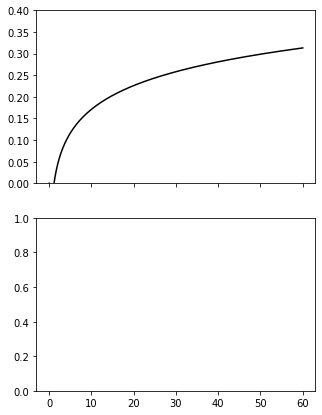

In [10]:
#plot overlaid data
fig, ax = plt.subplots(2, sharex = True, figsize = (5, 7))

ax[0].set_ylim(0, 0.4)

ax[0].plot(x,
           WT_pred,
           color = 'black')
ax[0].plot(ts2,
           wt2,
           linestyle = ':',
           color = 'red')
ax[0].scatter(time,
              WT_data,
              marker = 's',
              color = 'black')
ax[0].scatter(time,
              wt_scatter2,
              marker = 'o',
              color = 'red')

ax[0].set_xlabel('Time (min)')
ax[0].set_ylabel('Fraction diced')
ax[0].set_title('Wild-type')

ax[1].set_ylim(0, 0.014)

ax[1].plot(x,
           short_pred,
           color = 'black')
ax[1].plot(ts2,
           short2,
           linestyle = ':',
           color = 'red')
ax[1].scatter(time,
              short_data,
              marker = 's',
              color = 'black')
ax[1].scatter(time,
              short_scatter2,
              marker = 'o',
              color = 'red')

ax[1].set_xlabel('Time (min)')
ax[1].set_ylabel('Fraction diced')
ax[1].set_title('Short loop')

l1 = mlines.Line2D([], [], marker = 's', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', marker = 'o', color = 'red', label = 'model')

plt.legend(handles = [l1, l2], loc = 2)

plt.tight_layout()

plt.savefig('./figures/overlay_optims.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [2]:
#import parameters as obtained from optimisation used in further simulations
import params

In [3]:
ka1, ka2, kc1, kc2, kd1, kd2 = params.theta #final line in outputcmaes/xrecentbest.dat
output = solve_ivp(optim_model, (0, int(minutes)), init_values, \
                    method = 'LSODA', args = (ka1, ka2, kc1, kc2, kd1, kd2))

NameError: name 'optim_model' is not defined

In [13]:
#unpack species
order = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'dicer', 'miR']
wt_res = {}
short_res = {}

j = 0
for i in range(len(output.y)):
    if i%2 == 0:
        wt_res[order[j]] = output.y[i]
        if order[j] == 'dicer':
            wt_res['dicer_scaled'] = output.y[i] / 5
    else:
        short_res[order[j]] = output.y[i]
        if order[j] == 'dicer':
            short_res['dicer_scaled'] = output.y[i] / 5
        j += 1

In [14]:
colors = [i[0] for i in params.colors] + ['#88CCEE']
lines = ['-', ':', '--', '-.', '-']
to_plot = ['pMiR', 'miR', 'pMiR_dicer', 'pMiR_dicer_star', 'dicer_scaled']

In [4]:
import matplotlib.lines as mlines

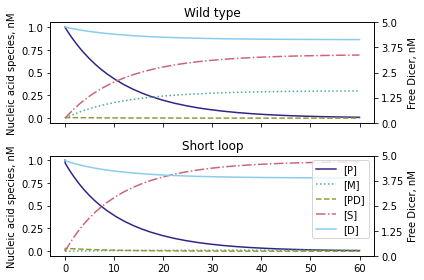

In [16]:
fig, ax = plt.subplots(2, sharex = True, sharey = True)

for i in range(len(to_plot)):
    ax[0].plot(output.t,
               wt_res[to_plot[i]],
               color = colors[i],
               linestyle = lines[i])
ax[0].set_yticks(np.linspace(0,1,5), labels = np.linspace(0,1,5))
ax[0].set_ylabel('Nucleic acid species, nM')
ax0 = ax[0].twinx()
ax0.set_yticks(np.linspace(0,1,5), labels = np.linspace(0,5,5))
ax0.set_ylabel('Free Dicer, nM')

ax[0].set_title('Wild type')

for i in range(len(to_plot)):
    ax[1].plot(output.t,
               short_res[to_plot[i]],
               color = colors[i],
               linestyle = lines[i])
ax[1].set_yticks(np.linspace(0,1,5), labels = np.linspace(0,1,5))
ax[1].set_ylabel('Nucleic acid species, nM')
ax1 = ax[1].twinx()
ax1.set_yticks(np.linspace(0,1,5), labels = np.linspace(0,5,5))
ax1.set_ylabel('Free Dicer, nM')

ax[1].set_title('Short loop')

leg = []
for i in range(len(colors)):
    leg.append(mlines.Line2D([], [], linestyle = lines[i], color = colors[i], 
                             label = ['[P]', '[M]', '[PD]', '[S]', '[D]'][i]))
               
plt.legend(handles = leg, loc = 1)

fig.tight_layout()

#plt.savefig('./figures/overlay_species.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

## Investigate effects of scaling ks, pre-miRNA concentration, Dicer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import params
import model_utils as mu
from tqdm import tqdm
from scipy.integrate import solve_ivp

C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Sofia\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#params
ka = [params.ka1]
kb = [params.ka1 * params.Kd_wt]
kc = [params.kc1]
kd = [params.kd1]
ks = [ka, kb, kc, kd] 
inits = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1]

In [3]:
#variation of ks, dicer concentration (single miRNA)
kvars = [10**i for i in list(np.linspace(-2,2,9))]
dvars = np.linspace(0, 7.25, 15)
dvars[0] = 0.01
dvars = np.append(dvars, np.linspace(10, 15, 4))

In [4]:
#set up ODEs, make model
ode = mu.makeODEs(inits + [0], ka, kb, kc, kd)

In [5]:
model = mu.makeModel(ode)

### Run model and save output

In [6]:
exec(model)

In [7]:
names = []
for i in tqdm(range(len(dvars))):
    for k in range(4):
        for j in range(len(kvars)):
            init = inits + [dvars[i]]
            if k == 0:
                ks = ([ka[0] * kvars[j]], kb, kc, kd)
            elif k == 1:
                ks = (ka, [kb[0] * kvars[j]], kc, kd)
            elif k == 2:
                ks = (ka, kb, [kc[0] * kvars[j]], kd)
            elif k == 3:
                ks = (ka, kb, kc, [kd[0] * kvars[j]])
            
            res = solve_ivp(runModel, (0, 3000), init, \
                            args = ks, method = 'LSODA',
                           atol = 1e-3)
            
            index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
            
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
            
            name = 'k' + ['a', 'b', 'c', 'd'][k] + '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(dvars[i]*100))
            names.append(name)
            
            df.to_csv('outputs/optim/csvs/' + name + '.csv', index = False)

100%|██████████| 19/19 [00:01<00:00, 12.97it/s]


In [8]:
for name in names:
    exec(name + ' = pd.read_csv("outputs/optim/csvs/' + name + '.csv", header = [0])')

In [9]:
ends = np.zeros((4, len(kvars), len(dvars)))

for i in range(4):
    for j in range(len(kvars)):
        for k in range(len(dvars)):
            exec('miR = k' + ['a', 'b', 'c', 'd'][i]+ '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(dvars[k]*100)))
            
            ends[i, j, k] = miR['miR'].iloc[-1]

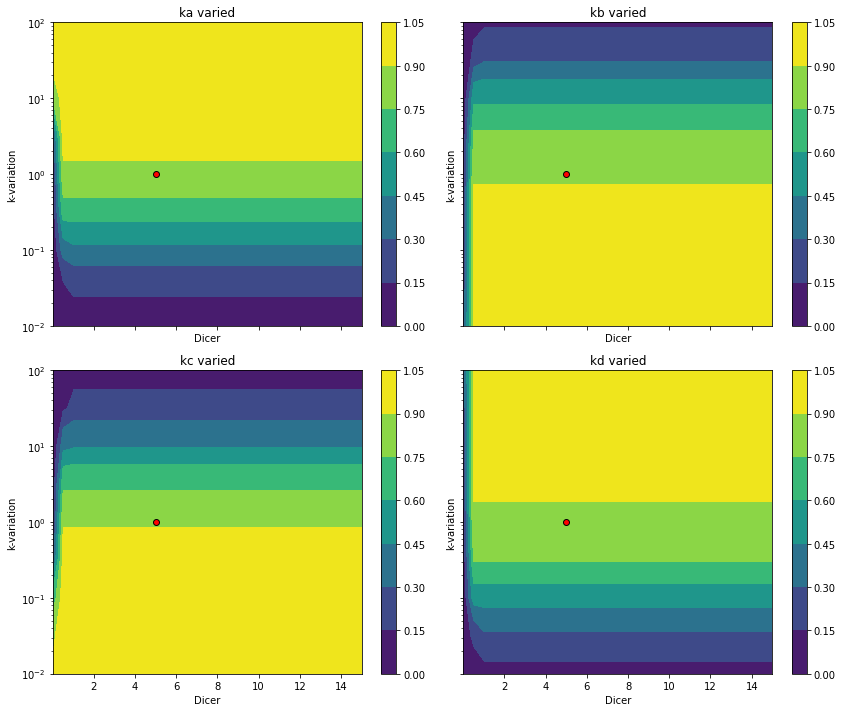

In [10]:
#plot
fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12, 10))

x = dvars
y = kvars

cs0 = ax[0,0].contourf(x, y, ends[0], vmin = 0, vmax = 1)
ax[0,0].set_title('ka varied')
fig.colorbar(cs0)
ax[0,0].set_xlabel('Dicer')
ax[0,0].set_ylabel('k-variation')
ax[0,0].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[0,0].set_yscale('log')

cs1 = ax[0,1].contourf(x, y, ends[1], vmin = 0, vmax = 1)
ax[0,1].set_title('kb varied')
fig.colorbar(cs1)
ax[0,1].set_xlabel('Dicer')
ax[0,1].set_ylabel('k-variation')
ax[0,1].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[0,1].set_yscale('log')

cs2 = ax[1,0].contourf(x, y, ends[2], vmin = 0, vmax = 1)
ax[1,0].set_title('kc varied')
fig.colorbar(cs2)
ax[1,0].set_xlabel('Dicer')
ax[1,0].set_ylabel('k-variation')
ax[1,0].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[1,0].set_yscale('log')

cs3 = ax[1,1].contourf(x, y, ends[3], vmin = 0, vmax = 1)
ax[1,1].set_title('kd varied')
fig.colorbar(cs3)
ax[1,1].set_xlabel('Dicer')
ax[1,1].set_ylabel('k-variation')
ax[1,1].scatter(5, 1, edgecolor = 'black', color = 'red')
ax[1,1].set_yscale('log')

fig.tight_layout()

plt.savefig('outputs/optim/plots/k-var_dvars2.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [11]:
#what happens when increasing pmir concentration?
pvars = np.linspace(0, 1, 5)
pvars = np.append(pvars, np.linspace(1.5, 5, 8))
inits = [params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1]

In [12]:
names2 = []
for i in tqdm(range(len(dvars))):
    for j in range(len(pvars)):
        init = [pvars[j]] + inits + [dvars[i]]
            
        res = solve_ivp(runModel, (0, 3000), init, args = (ka, kb, kc, kd), method = 'LSODA')
            
        index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
            
        df = pd.DataFrame(res.y, index = index)
        df = df.transpose()
        df.insert(loc = 0, column = 'time_min', value = res.t)
            
        name = 'pvar_' + str(int(pvars[j]*100)) + 'dvar_' + str(int(dvars[i]*100))
        names2.append(name)
            
        df.to_csv('outputs/optim/csvs/' + name + '.csv', index = False)

100%|██████████| 19/19 [00:00<00:00, 25.14it/s]


In [13]:
for name in names2:
    exec(name + ' = pd.read_csv("outputs/optim/csvs/' + name + '.csv", header = [0])')

In [52]:
ends2 = np.zeros((len(pvars), len(dvars)))

for j in range(len(pvars)):
    for k in range(len(dvars)):
        exec('miR = pvar_' + str(int(pvars[j]*100)) + 'dvar_' + str(int(dvars[k]*100)))
            
        ends2[j, k] = miR['miR'].iloc[-1]

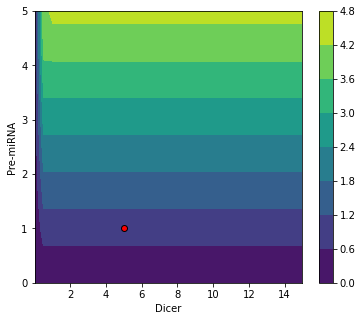

In [53]:
fig, ax = plt.subplots(figsize = (6,5))

x = dvars
y = pvars

cs = ax.contourf(x, y, ends2, vmin = 0, vmax = 5)
fig.colorbar(cs)
ax.set_xlabel('Dicer')
ax.set_ylabel('Pre-miRNA')
ax.scatter(5, 1, edgecolor = 'black', color = 'red')

plt.savefig('outputs/optim/plots/premir-conc.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [17]:
inits = [params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, 
                 params.init_MiR1, params.init_dcr1]

In [18]:
names3 = []
for i in tqdm(range(len(pvars))):
    for j in range(len(kvars)):
        for k in range(4):
            init = [pvars[i]] + inits 
            if k == 0:
                ks = ([ka[0] * kvars[j]], kb, kc, kd)
            elif k == 1:
                ks = (ka, [kb[0] * kvars[j]], kc, kd)
            elif k == 2:
                ks = (ka, kb, [kc[0] * kvars[j]], kd)
            elif k == 3:
                ks = (ka, kb, kc, [kd[0] * kvars[j]])
            
            res = solve_ivp(runModel, (0, 3000), init, \
                            args = ks, method = 'LSODA',
                           atol = 1e-3)
            
            index = ['pMiR', 'pMiR_dicer', 'pMiR_dicer_star', 'miR', 'dicer']
            
            df = pd.DataFrame(res.y, index = index)
            df = df.transpose()
            df.insert(loc = 0, column = 'time_min', value = res.t)
            
            name = 'k' + ['a', 'b', 'c', 'd'][k] + '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(pvars[i]*100))
            names3.append(name)
            
            df.to_csv('outputs/optim/csvs/' + name + '.csv', index = False)

100%|██████████| 13/13 [00:01<00:00, 12.51it/s]


In [19]:
for name in names3:
    exec(name + ' = pd.read_csv("outputs/optim/csvs/' + name + '.csv", header = [0])')

In [20]:
ends3 = np.zeros((4, len(kvars), len(pvars)))

for i in range(4):
    for j in range(len(kvars)):
        for k in range(len(pvars)):
            exec('miR = k' + ['a', 'b', 'c', 'd'][i]+ '_' + str(int(kvars[j]*100)) + 'dvar_' + str(int(pvars[k]*100)))
            
            ends3[i, j, k] = miR['miR'].iloc[-1]

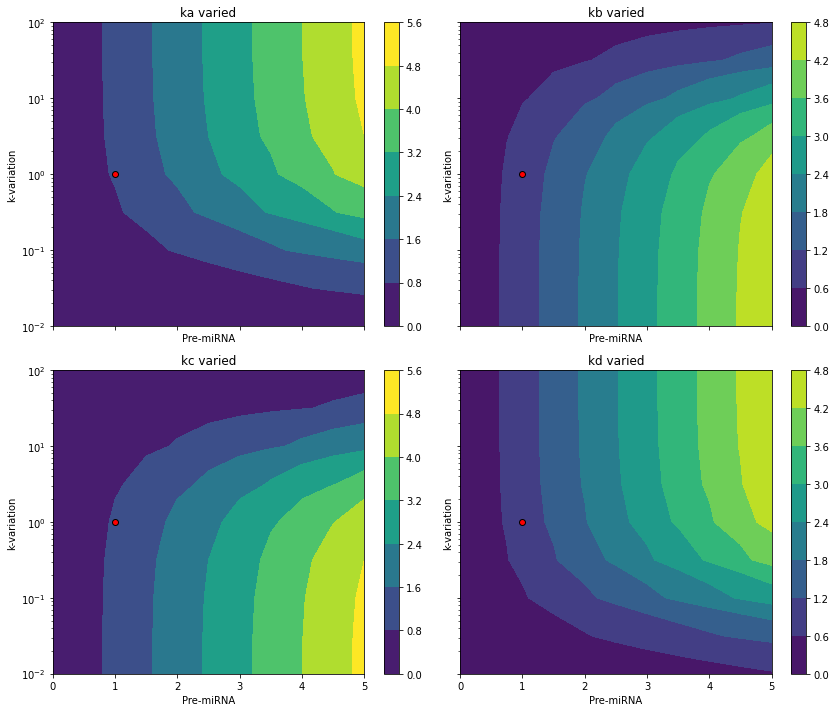

In [21]:
#plot
fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (12, 10))

x = pvars
y = kvars

cs0 = ax[0,0].contourf(x, y, ends3[0], vmin = 0, vmax = 5)
ax[0,0].set_title('ka varied')
fig.colorbar(cs0)
ax[0,0].set_xlabel('Pre-miRNA')
ax[0,0].set_ylabel('k-variation')
ax[0,0].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[0,0].set_yscale('log')

cs1 = ax[0,1].contourf(x, y, ends3[1], vmin = 0, vmax = 5)
ax[0,1].set_title('kb varied')
fig.colorbar(cs1)
ax[0,1].set_xlabel('Pre-miRNA')
ax[0,1].set_ylabel('k-variation')
ax[0,1].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[0,1].set_yscale('log')

cs2 = ax[1,0].contourf(x, y, ends3[2], vmin = 0, vmax = 5)
ax[1,0].set_title('kc varied')
fig.colorbar(cs2)
ax[1,0].set_xlabel('Pre-miRNA')
ax[1,0].set_ylabel('k-variation')
ax[1,0].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[1,0].set_yscale('log')

cs3 = ax[1,1].contourf(x, y, ends3[3], vmin = 0, vmax = 5)
ax[1,1].set_title('kd varied')
fig.colorbar(cs3)
ax[1,1].set_xlabel('Pre-miRNA')
ax[1,1].set_ylabel('k-variation')
ax[1,1].scatter(1, 1, edgecolor = 'black', color = 'red')
ax[1,1].set_yscale('log')

fig.tight_layout()

plt.savefig('outputs/optim/plots/k-var_pvars.svg', dpi = 600, bbox_inches = 'tight')
plt.show()